In [1]:
#це додав індус для енкодера(шоб міняти слова на 0,1,2,..(тіпа а, б, а, В = 0, 1, 0, 2))
from sklearn.preprocessing import LabelEncoder
#штучка шоб заповнити всі нан на медіану
from sklearn.impute import SimpleImputer

#torch
import torch
import torch.nn as nn
import torch.optim as optim

#base libs
import sklearn
import numpy as np

#dataset
import pandas as pd
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split as split

#visualization
import missingno as msno
import seaborn as sn
import matplotlib.pyplot as plt

#models
from sklearn.decomposition import PCA
from sklearn.svm import SVC

#metrics
from sklearn.metrics import classification_report, confusion_matrix 

In [2]:
df = pd.read_csv('train.csv')
df = df.drop(columns=['Name', 'Ticket'])
df_train, df_test = split(df, test_size = 0.2, shuffle = True, random_state = 11)

In [3]:
# df.isnull().sum()/len(df)

In [4]:
df["Survived"].value_counts(normalize=True)

Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

In [5]:
df_test

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
431,432,1,3,female,NaN,1,0,16.1000,NaN,S
821,822,1,3,male,27.0,0,0,8.6625,NaN,S
629,630,0,3,male,NaN,0,0,7.7333,NaN,Q
626,627,0,2,male,57.0,0,0,12.3500,NaN,Q
665,666,0,2,male,32.0,2,0,73.5000,NaN,S
...,...,...,...,...,...,...,...,...,...,...
638,639,0,3,female,41.0,0,5,39.6875,NaN,S
771,772,0,3,male,48.0,0,0,7.8542,NaN,S
521,522,0,3,male,22.0,0,0,7.8958,NaN,S
711,712,0,1,male,NaN,0,0,26.5500,C124,S


In [6]:
le = LabelEncoder()
le_sex = LabelEncoder()
le_embraked = LabelEncoder()
le_cabin = LabelEncoder()
def preprocess_data(df, fit=True):

    if 'Sex' in df.columns:
        if fit:
            df['Sex'] = le_sex.fit_transform(df['Sex'])
        else:
            df['Sex'] = le_sex.transform(df['Sex'])

    if 'Embarked' in df.columns:
        if fit:
            df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode())
            df['Embarked'] = le_embraked.fit_transform(df['Embarked'])
        else:
            df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode())
            df['Embarked'] = le_embraked.transform(df['Embarked'])
  
    if 'Cabin' in df.columns:
        if fit:
            df['Cabin'] = df['Cabin'].str[0]
            df['Cabin'] = le_cabin.fit_transform(df['Cabin'])
        else:
            df['Cabin'] = df['Cabin'].str[0]
            df['Cabin'] = le_cabin.transform(df['Cabin'])

    if 'Age' in df.columns:
        df['Age'] = df['Age'].round().astype('Int64')
        df['Age'] = df['Age'].fillna(df_train['Age'].median())
        
    return df


In [7]:
preprocessed_df_train = preprocess_data(df_train, fit=True)
preprocessed_df_test = preprocess_data(df_test, fit=False)

In [8]:
X_train = df_train[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Cabin", "Embarked"]]
y_train = df_train["Survived"]
x_test = df_test[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Cabin", "Embarked"]]
y_test = df_test['Survived']
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
x_test = scaler.transform(x_test)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Cabin        204 non-null    object 
 9   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


In [10]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Cabin          687
Embarked         2
dtype: int64

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


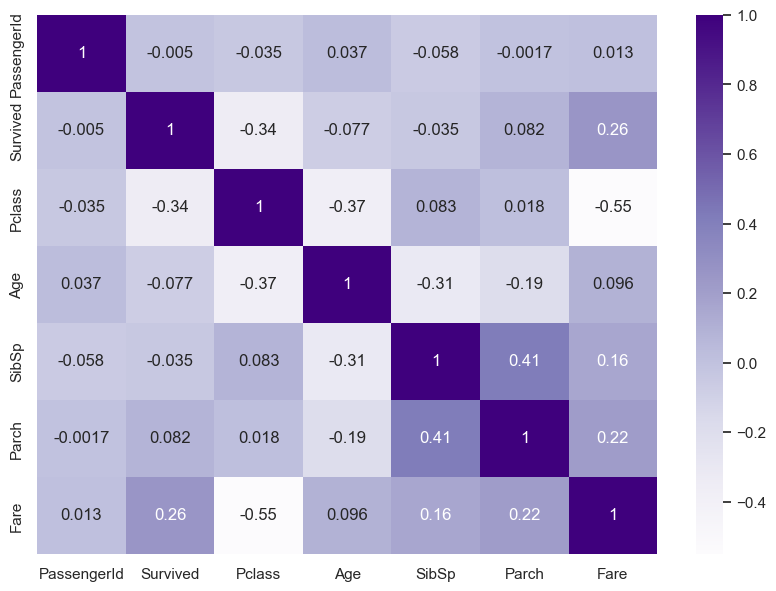

In [11]:
corr = df.select_dtypes(include=["int64", "float64"]).corr()
sn.set(rc = {
    "figure.figsize": (10, 7)
})
sn.heatmap(corr, annot = True, cmap = "Purples")
corr

In [12]:
df.describe(percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
1%,9.900000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
5%,45.500000,0.000000,1.000000,4.000000,0.000000,0.000000,7.225000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
95%,846.500000,1.000000,3.000000,56.000000,3.000000,2.000000,112.079150


In [13]:
df.shape

(891, 10)

In [14]:
minmax = preprocessing.MinMaxScaler()
X = X_train
y = y_train.values

X_sc = minmax.fit_transform(X)
df.describe().loc[["min","max"]].T

,min,max
PassengerId,1.00,891.0000
Survived,0.00,1.0000
Pclass,1.00,3.0000
Age,0.42,80.0000
SibSp,0.00,8.0000
Parch,0.00,6.0000
Fare,0.00,512.3292


In [15]:
pca = PCA()
pca.fit(X_sc)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [16]:
pca_range = np.arange(1, X_sc.shape[1] + 1)
pca_range

array([1, 2, 3, 4, 5, 6, 7, 8])

In [17]:
model = SVC()
model.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [18]:
predictions = model.predict(x_test)
predictions

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0])

In [19]:
# Weather Survived or not: 0 = No, 1 = Yes

In [20]:
print(classification_report(y_test, predictions, digits = 2))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       118
           1       0.86      0.72      0.79        61

    accuracy                           0.87       179
   macro avg       0.86      0.83      0.84       179
weighted avg       0.87      0.87      0.86       179

